In [1]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [2]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
print ("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False


In [4]:
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
    device_name = '/CPU:0'
print(device_name)

/CPU:0


In [5]:

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## define a function for the generator:
def make_generator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784):

    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
      model.add(
        tf.keras.layers.Dense(
            units=num_hidden_units, use_bias=False))
      model.add(tf.keras.layers.LeakyReLU())

    model.add(
      tf.keras.layers.Dense(
        units=num_output_units, activation='tanh'))
    return model
## define a function for the discriminator:

def make_discriminator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(units=num_hidden_units))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(
    tf.keras.layers.Dense(
        units=num_output_units, activation=None))
  return model

In [6]:

image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
tf.random.set_seed(1)
gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

#The Generator network 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │        79,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,184 (317.12 KB)

 Trainable params: 81,184 (317.12 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

#The Discriminator network

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,601 (307.04 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image

mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

In [9]:

mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape:   ', input_z.shape)
print('input-real -- shape:', input_real.shape)



input-z -- shape:    (32, 20)
input-real -- shape: (32, 784)


2024-05-08 13:32:39.481160: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)


Output of G -- shape: (32, 784)


In [14]:
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_logits_real.shape)
print('Disc. (fake) -- shape:', d_logits_fake.shape)

Disc. (real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


In [15]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
## Loss for the Generator
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))

Generator Loss: 0.6779


In [16]:
## Loss for the Discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)
d_loss_real = loss_fn(y_true=d_labels_real,
                      y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                      y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 0.2591 Fake 0.7155


In [21]:
import time
num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
tf.random.set_seed(1)
np.random.seed(1)
if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
    shape=(batch_size, z_size),
    minval=-1, maxval=1)

elif mode_z == 'normal':
  fixed_z = tf.random.normal(
         shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0


## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)


## Set-up the model
with tf.device(device_name):
  gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))

  disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))


## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
  epoch_losses, epoch_d_vals = [], []

  for i,(input_z,input_real) in enumerate(mnist_trainset):
    ## Compute generator's loss
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output,
                              training=True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real,
                    y_pred=d_logits_fake)

    ## Compute the gradients of g_loss
    g_grads = g_tape.gradient(g_loss,
                              gen_model.trainable_variables)

    ## Optimization: Apply the gradients
    g_optimizer.apply_gradients(
      grads_and_vars=zip(g_grads,
      gen_model.trainable_variables))

    ## Compute discriminator's loss
    with tf.GradientTape() as d_tape:
      d_logits_real = disc_model(input_real,
                                training=True)
      d_labels_real = tf.ones_like(d_logits_real)
      d_loss_real = loss_fn(
          y_true=d_labels_real, y_pred=d_logits_real)
      d_logits_fake = disc_model(g_output,
                                training=True)
      d_labels_fake = tf.zeros_like(d_logits_fake)
      d_loss_fake = loss_fn(
          y_true=d_labels_fake, y_pred=d_logits_fake)
      d_loss = d_loss_real + d_loss_fake
    ## Compute the gradients of d_loss
    d_grads = d_tape.gradient(d_loss,
              disc_model.trainable_variables)


    ## Optimization: Apply the gradients
    d_optimizer.apply_gradients(
      grads_and_vars=zip(d_grads,
      disc_model.trainable_variables))

    epoch_losses.append(
      (g_loss.numpy(), d_loss.numpy(),
      d_loss_real.numpy(), d_loss_fake.numpy()))

    d_probs_real = tf.reduce_mean(
                    tf.sigmoid(d_logits_real))
    d_probs_fake = tf.reduce_mean(
                    tf.sigmoid(d_logits_fake))
    epoch_d_vals.append((d_probs_real.numpy(),
                      d_probs_fake.numpy()))
  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)
  print(
    'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
    ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
    .format(
        epoch, (time.time() - start_time)/60,
        *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(
    create_samples(gen_model, fixed_z).numpy())





2024-05-08 14:22:04.812583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 001 | ET 0.30 min | Avg Losses >> G/D 2.9218/0.2929 [D-Real: 0.0351 D-Fake: 0.2579]


2024-05-08 14:22:22.092980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 002 | ET 0.58 min | Avg Losses >> G/D 5.2042/0.3272 [D-Real: 0.1012 D-Fake: 0.2260]


2024-05-08 14:22:39.292508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 003 | ET 0.87 min | Avg Losses >> G/D 3.5955/0.6576 [D-Real: 0.2914 D-Fake: 0.3662]


2024-05-08 14:22:56.725214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 004 | ET 1.16 min | Avg Losses >> G/D 1.8956/0.9505 [D-Real: 0.4792 D-Fake: 0.4713]


2024-05-08 14:23:14.077587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 005 | ET 1.45 min | Avg Losses >> G/D 1.9762/0.8732 [D-Real: 0.4630 D-Fake: 0.4102]


2024-05-08 14:23:31.442013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 006 | ET 1.74 min | Avg Losses >> G/D 1.8060/0.8884 [D-Real: 0.4860 D-Fake: 0.4025]


2024-05-08 14:23:48.623039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 007 | ET 2.03 min | Avg Losses >> G/D 1.6557/0.9596 [D-Real: 0.5132 D-Fake: 0.4464]


2024-05-08 14:24:05.928828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 008 | ET 2.31 min | Avg Losses >> G/D 1.5810/0.9710 [D-Real: 0.5302 D-Fake: 0.4408]


2024-05-08 14:24:23.159795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 009 | ET 2.60 min | Avg Losses >> G/D 1.4410/0.9834 [D-Real: 0.5448 D-Fake: 0.4385]


2024-05-08 14:24:40.219198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 010 | ET 2.89 min | Avg Losses >> G/D 1.4954/0.9816 [D-Real: 0.5372 D-Fake: 0.4444]


2024-05-08 14:24:57.384887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 011 | ET 3.17 min | Avg Losses >> G/D 1.4598/1.0597 [D-Real: 0.5602 D-Fake: 0.4995]


2024-05-08 14:25:14.585596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 012 | ET 3.46 min | Avg Losses >> G/D 1.3136/1.0609 [D-Real: 0.5672 D-Fake: 0.4938]


2024-05-08 14:25:31.831434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 013 | ET 3.75 min | Avg Losses >> G/D 1.2851/1.1164 [D-Real: 0.5840 D-Fake: 0.5325]


2024-05-08 14:25:49.325806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 014 | ET 4.04 min | Avg Losses >> G/D 1.2712/1.1588 [D-Real: 0.6016 D-Fake: 0.5573]


2024-05-08 14:26:06.504882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 015 | ET 4.32 min | Avg Losses >> G/D 1.1962/1.1584 [D-Real: 0.6007 D-Fake: 0.5576]


2024-05-08 14:26:23.648498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 016 | ET 4.61 min | Avg Losses >> G/D 1.2004/1.1605 [D-Real: 0.5993 D-Fake: 0.5612]


2024-05-08 14:26:41.045182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 017 | ET 4.90 min | Avg Losses >> G/D 1.1634/1.1580 [D-Real: 0.6013 D-Fake: 0.5567]


2024-05-08 14:26:58.356769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 018 | ET 5.19 min | Avg Losses >> G/D 1.2429/1.1535 [D-Real: 0.5977 D-Fake: 0.5558]


2024-05-08 14:27:15.604679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 019 | ET 5.48 min | Avg Losses >> G/D 1.1440/1.1897 [D-Real: 0.6098 D-Fake: 0.5799]


2024-05-08 14:27:32.951051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 020 | ET 5.76 min | Avg Losses >> G/D 1.1187/1.1976 [D-Real: 0.6133 D-Fake: 0.5843]


2024-05-08 14:27:50.394395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 021 | ET 6.06 min | Avg Losses >> G/D 1.1071/1.2318 [D-Real: 0.6278 D-Fake: 0.6040]


2024-05-08 14:28:07.573895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 022 | ET 6.34 min | Avg Losses >> G/D 1.1217/1.2158 [D-Real: 0.6194 D-Fake: 0.5965]


2024-05-08 14:28:25.214671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 023 | ET 6.64 min | Avg Losses >> G/D 1.0252/1.2306 [D-Real: 0.6275 D-Fake: 0.6030]


2024-05-08 14:28:42.617124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 024 | ET 6.93 min | Avg Losses >> G/D 1.0819/1.2258 [D-Real: 0.6236 D-Fake: 0.6021]


2024-05-08 14:28:59.792595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 025 | ET 7.21 min | Avg Losses >> G/D 1.0905/1.2375 [D-Real: 0.6239 D-Fake: 0.6136]


2024-05-08 14:29:16.896465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 026 | ET 7.50 min | Avg Losses >> G/D 1.0563/1.2407 [D-Real: 0.6271 D-Fake: 0.6137]


2024-05-08 14:29:34.010040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 027 | ET 7.78 min | Avg Losses >> G/D 0.9568/1.2730 [D-Real: 0.6451 D-Fake: 0.6279]


2024-05-08 14:29:51.181066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 028 | ET 8.07 min | Avg Losses >> G/D 1.0342/1.2330 [D-Real: 0.6277 D-Fake: 0.6054]


2024-05-08 14:30:08.404100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 029 | ET 8.36 min | Avg Losses >> G/D 1.1013/1.2206 [D-Real: 0.6173 D-Fake: 0.6033]


2024-05-08 14:30:25.786532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 030 | ET 8.65 min | Avg Losses >> G/D 1.0286/1.2454 [D-Real: 0.6304 D-Fake: 0.6150]


2024-05-08 14:30:43.192535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 031 | ET 8.94 min | Avg Losses >> G/D 0.9918/1.2527 [D-Real: 0.6346 D-Fake: 0.6181]


2024-05-08 14:31:00.277506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 032 | ET 9.22 min | Avg Losses >> G/D 0.9931/1.2722 [D-Real: 0.6402 D-Fake: 0.6320]


2024-05-08 14:31:17.600576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 033 | ET 9.51 min | Avg Losses >> G/D 1.0288/1.2632 [D-Real: 0.6346 D-Fake: 0.6285]


2024-05-08 14:31:34.852664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 034 | ET 9.80 min | Avg Losses >> G/D 0.9930/1.2706 [D-Real: 0.6407 D-Fake: 0.6300]


2024-05-08 14:31:52.058524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 035 | ET 10.08 min | Avg Losses >> G/D 0.9623/1.2890 [D-Real: 0.6486 D-Fake: 0.6404]


2024-05-08 14:32:09.230835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 036 | ET 10.37 min | Avg Losses >> G/D 0.9318/1.3068 [D-Real: 0.6571 D-Fake: 0.6496]


2024-05-08 14:32:26.573191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 037 | ET 10.66 min | Avg Losses >> G/D 1.0151/1.2722 [D-Real: 0.6393 D-Fake: 0.6329]


2024-05-08 14:32:43.811892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 038 | ET 10.95 min | Avg Losses >> G/D 1.0194/1.2712 [D-Real: 0.6386 D-Fake: 0.6326]


2024-05-08 14:33:01.197213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 039 | ET 11.24 min | Avg Losses >> G/D 0.9978/1.2732 [D-Real: 0.6401 D-Fake: 0.6331]


2024-05-08 14:33:19.274806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 040 | ET 11.54 min | Avg Losses >> G/D 0.9470/1.2866 [D-Real: 0.6479 D-Fake: 0.6387]


2024-05-08 14:33:36.640120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 041 | ET 11.83 min | Avg Losses >> G/D 0.9864/1.2793 [D-Real: 0.6436 D-Fake: 0.6357]


2024-05-08 14:33:53.976845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 042 | ET 12.12 min | Avg Losses >> G/D 0.9476/1.3014 [D-Real: 0.6538 D-Fake: 0.6476]


2024-05-08 14:34:11.517643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 043 | ET 12.41 min | Avg Losses >> G/D 0.9359/1.3062 [D-Real: 0.6556 D-Fake: 0.6506]


2024-05-08 14:34:28.735027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 044 | ET 12.69 min | Avg Losses >> G/D 0.9377/1.3125 [D-Real: 0.6592 D-Fake: 0.6533]


2024-05-08 14:34:46.566900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 045 | ET 12.99 min | Avg Losses >> G/D 0.9802/1.2949 [D-Real: 0.6500 D-Fake: 0.6450]


2024-05-08 14:35:03.842435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 046 | ET 13.28 min | Avg Losses >> G/D 1.0041/1.2822 [D-Real: 0.6446 D-Fake: 0.6376]


2024-05-08 14:35:22.005042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 047 | ET 13.58 min | Avg Losses >> G/D 0.9956/1.2729 [D-Real: 0.6400 D-Fake: 0.6329]


2024-05-08 14:35:39.278891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 048 | ET 13.87 min | Avg Losses >> G/D 0.9420/1.2905 [D-Real: 0.6496 D-Fake: 0.6409]


2024-05-08 14:35:56.320535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 049 | ET 14.15 min | Avg Losses >> G/D 0.9104/1.3068 [D-Real: 0.6579 D-Fake: 0.6488]


2024-05-08 14:36:13.181834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 050 | ET 14.44 min | Avg Losses >> G/D 0.9541/1.3018 [D-Real: 0.6527 D-Fake: 0.6491]


2024-05-08 14:36:30.568267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 051 | ET 14.73 min | Avg Losses >> G/D 0.9865/1.2789 [D-Real: 0.6428 D-Fake: 0.6361]


2024-05-08 14:36:47.611315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 052 | ET 15.01 min | Avg Losses >> G/D 0.9226/1.3039 [D-Real: 0.6557 D-Fake: 0.6482]


2024-05-08 14:37:04.399505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 053 | ET 15.29 min | Avg Losses >> G/D 0.9149/1.3129 [D-Real: 0.6599 D-Fake: 0.6530]


2024-05-08 14:37:21.561819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 054 | ET 15.57 min | Avg Losses >> G/D 0.9484/1.2961 [D-Real: 0.6466 D-Fake: 0.6495]


2024-05-08 14:37:38.587676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 055 | ET 15.86 min | Avg Losses >> G/D 0.9142/1.3192 [D-Real: 0.6625 D-Fake: 0.6567]


2024-05-08 14:37:55.571753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 056 | ET 16.14 min | Avg Losses >> G/D 0.8998/1.3150 [D-Real: 0.6590 D-Fake: 0.6561]


2024-05-08 14:38:12.457738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 057 | ET 16.42 min | Avg Losses >> G/D 0.9482/1.3062 [D-Real: 0.6562 D-Fake: 0.6500]


2024-05-08 14:38:29.548871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 058 | ET 16.71 min | Avg Losses >> G/D 0.9659/1.3008 [D-Real: 0.6521 D-Fake: 0.6487]


2024-05-08 14:38:46.395948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 059 | ET 16.99 min | Avg Losses >> G/D 0.9166/1.3087 [D-Real: 0.6586 D-Fake: 0.6501]


2024-05-08 14:39:03.497370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 060 | ET 17.27 min | Avg Losses >> G/D 0.9437/1.3054 [D-Real: 0.6529 D-Fake: 0.6525]


2024-05-08 14:39:20.191159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 061 | ET 17.55 min | Avg Losses >> G/D 0.9321/1.2967 [D-Real: 0.6525 D-Fake: 0.6443]


2024-05-08 14:39:36.813130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 062 | ET 17.83 min | Avg Losses >> G/D 0.9444/1.3055 [D-Real: 0.6540 D-Fake: 0.6516]


2024-05-08 14:39:53.435071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 063 | ET 18.11 min | Avg Losses >> G/D 0.9622/1.2982 [D-Real: 0.6511 D-Fake: 0.6471]


2024-05-08 14:40:10.144388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 064 | ET 18.38 min | Avg Losses >> G/D 0.8985/1.3174 [D-Real: 0.6606 D-Fake: 0.6568]


2024-05-08 14:40:27.078177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 065 | ET 18.67 min | Avg Losses >> G/D 0.9146/1.3184 [D-Real: 0.6609 D-Fake: 0.6575]


2024-05-08 14:40:44.042276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 066 | ET 18.95 min | Avg Losses >> G/D 0.9667/1.2985 [D-Real: 0.6514 D-Fake: 0.6471]


2024-05-08 14:41:00.841504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 067 | ET 19.23 min | Avg Losses >> G/D 0.9192/1.3014 [D-Real: 0.6553 D-Fake: 0.6461]


2024-05-08 14:41:18.127065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 068 | ET 19.52 min | Avg Losses >> G/D 0.9171/1.3175 [D-Real: 0.6597 D-Fake: 0.6578]


2024-05-08 14:41:35.088117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 069 | ET 19.80 min | Avg Losses >> G/D 0.9394/1.2991 [D-Real: 0.6533 D-Fake: 0.6458]


2024-05-08 14:41:51.929984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 070 | ET 20.08 min | Avg Losses >> G/D 0.9211/1.3096 [D-Real: 0.6582 D-Fake: 0.6514]


2024-05-08 14:42:08.958944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 071 | ET 20.36 min | Avg Losses >> G/D 0.9035/1.3140 [D-Real: 0.6591 D-Fake: 0.6548]


2024-05-08 14:42:25.863409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 072 | ET 20.65 min | Avg Losses >> G/D 0.9388/1.3076 [D-Real: 0.6572 D-Fake: 0.6504]


2024-05-08 14:42:42.562376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 073 | ET 20.92 min | Avg Losses >> G/D 0.9223/1.3069 [D-Real: 0.6567 D-Fake: 0.6502]


2024-05-08 14:42:59.400632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 074 | ET 21.21 min | Avg Losses >> G/D 0.9031/1.3106 [D-Real: 0.6582 D-Fake: 0.6524]


2024-05-08 14:43:16.279393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 075 | ET 21.49 min | Avg Losses >> G/D 0.9257/1.3170 [D-Real: 0.6605 D-Fake: 0.6565]


2024-05-08 14:43:33.564319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 076 | ET 21.77 min | Avg Losses >> G/D 0.9130/1.3117 [D-Real: 0.6564 D-Fake: 0.6553]


2024-05-08 14:43:50.414552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 077 | ET 22.06 min | Avg Losses >> G/D 0.9129/1.3124 [D-Real: 0.6607 D-Fake: 0.6517]


2024-05-08 14:44:07.308637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 078 | ET 22.34 min | Avg Losses >> G/D 0.8921/1.3189 [D-Real: 0.6643 D-Fake: 0.6546]


2024-05-08 14:44:24.265140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 079 | ET 22.62 min | Avg Losses >> G/D 0.9210/1.3118 [D-Real: 0.6574 D-Fake: 0.6544]


2024-05-08 14:44:41.349908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 080 | ET 22.90 min | Avg Losses >> G/D 0.9116/1.3173 [D-Real: 0.6603 D-Fake: 0.6570]


2024-05-08 14:44:58.362549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 081 | ET 23.19 min | Avg Losses >> G/D 0.9099/1.3162 [D-Real: 0.6591 D-Fake: 0.6571]


2024-05-08 14:45:15.305078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 082 | ET 23.47 min | Avg Losses >> G/D 0.8871/1.3181 [D-Real: 0.6638 D-Fake: 0.6543]


2024-05-08 14:45:33.028756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 083 | ET 23.77 min | Avg Losses >> G/D 0.9496/1.3085 [D-Real: 0.6528 D-Fake: 0.6557]


2024-05-08 14:45:50.527025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 084 | ET 24.06 min | Avg Losses >> G/D 0.9427/1.3056 [D-Real: 0.6535 D-Fake: 0.6521]


2024-05-08 14:46:08.801184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 085 | ET 24.36 min | Avg Losses >> G/D 0.8859/1.3192 [D-Real: 0.6622 D-Fake: 0.6570]


2024-05-08 14:46:26.977276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 086 | ET 24.67 min | Avg Losses >> G/D 0.9035/1.3184 [D-Real: 0.6622 D-Fake: 0.6562]


2024-05-08 14:46:45.373898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 087 | ET 24.97 min | Avg Losses >> G/D 0.9055/1.3241 [D-Real: 0.6631 D-Fake: 0.6610]


2024-05-08 14:47:03.012757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 088 | ET 25.27 min | Avg Losses >> G/D 0.9232/1.3113 [D-Real: 0.6601 D-Fake: 0.6512]


2024-05-08 14:47:20.172321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 089 | ET 25.55 min | Avg Losses >> G/D 0.9098/1.3160 [D-Real: 0.6614 D-Fake: 0.6546]


2024-05-08 14:47:37.446741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 090 | ET 25.84 min | Avg Losses >> G/D 0.9251/1.3168 [D-Real: 0.6593 D-Fake: 0.6575]


2024-05-08 14:47:54.754864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 091 | ET 26.13 min | Avg Losses >> G/D 0.9336/1.3119 [D-Real: 0.6573 D-Fake: 0.6546]


2024-05-08 14:48:11.905375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 092 | ET 26.41 min | Avg Losses >> G/D 0.9010/1.3242 [D-Real: 0.6651 D-Fake: 0.6591]


2024-05-08 14:48:29.030584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 093 | ET 26.70 min | Avg Losses >> G/D 0.9498/1.3005 [D-Real: 0.6518 D-Fake: 0.6486]


2024-05-08 14:48:46.243640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 094 | ET 26.99 min | Avg Losses >> G/D 0.9015/1.3159 [D-Real: 0.6608 D-Fake: 0.6551]


2024-05-08 14:49:03.721310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 095 | ET 27.28 min | Avg Losses >> G/D 0.9102/1.3218 [D-Real: 0.6623 D-Fake: 0.6595]


2024-05-08 14:49:21.003395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 096 | ET 27.57 min | Avg Losses >> G/D 0.9543/1.3037 [D-Real: 0.6519 D-Fake: 0.6518]


2024-05-08 14:49:38.182393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 097 | ET 27.85 min | Avg Losses >> G/D 0.8663/1.3242 [D-Real: 0.6636 D-Fake: 0.6606]


2024-05-08 14:49:55.296694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 098 | ET 28.14 min | Avg Losses >> G/D 0.9256/1.3216 [D-Real: 0.6618 D-Fake: 0.6598]


2024-05-08 14:50:12.602305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 099 | ET 28.43 min | Avg Losses >> G/D 0.9363/1.3143 [D-Real: 0.6597 D-Fake: 0.6546]
Epoch 100 | ET 28.72 min | Avg Losses >> G/D 0.8912/1.3214 [D-Real: 0.6649 D-Fake: 0.6564]


2024-05-08 14:50:30.048490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


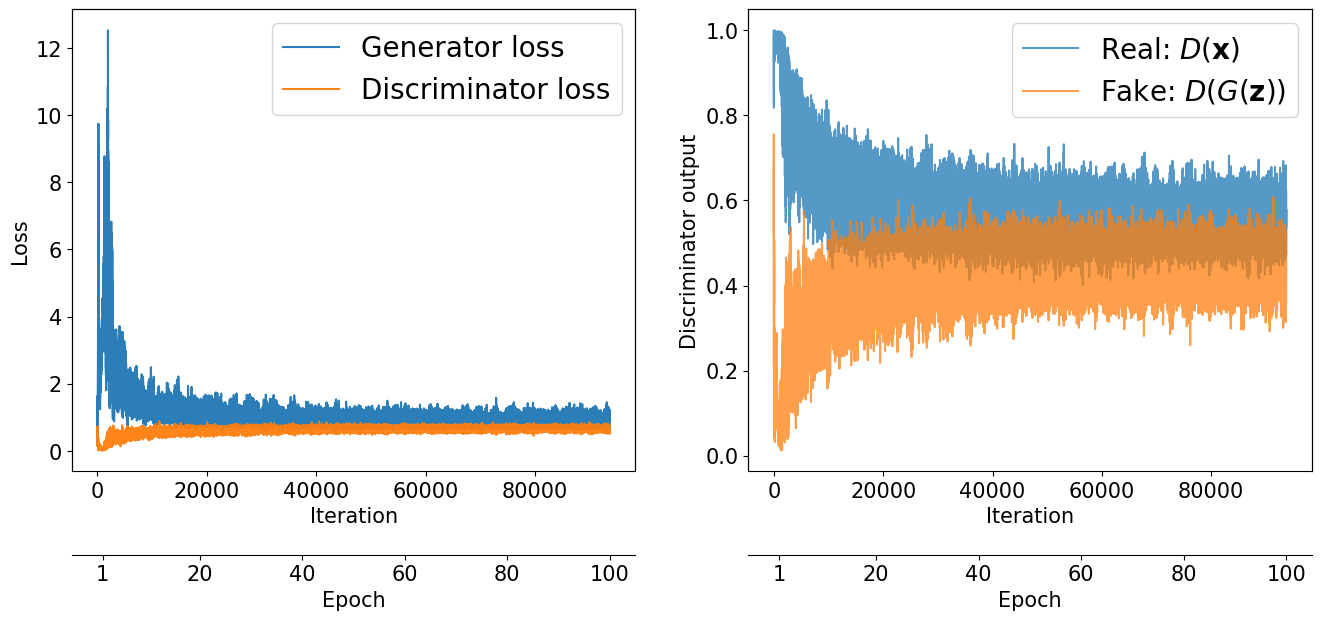

In [19]:
import itertools
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(
            *all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)


epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(
               *all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(
               *all_d_vals)]
plt.plot(d_vals_real, alpha=0.75,
         label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75,
         label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()


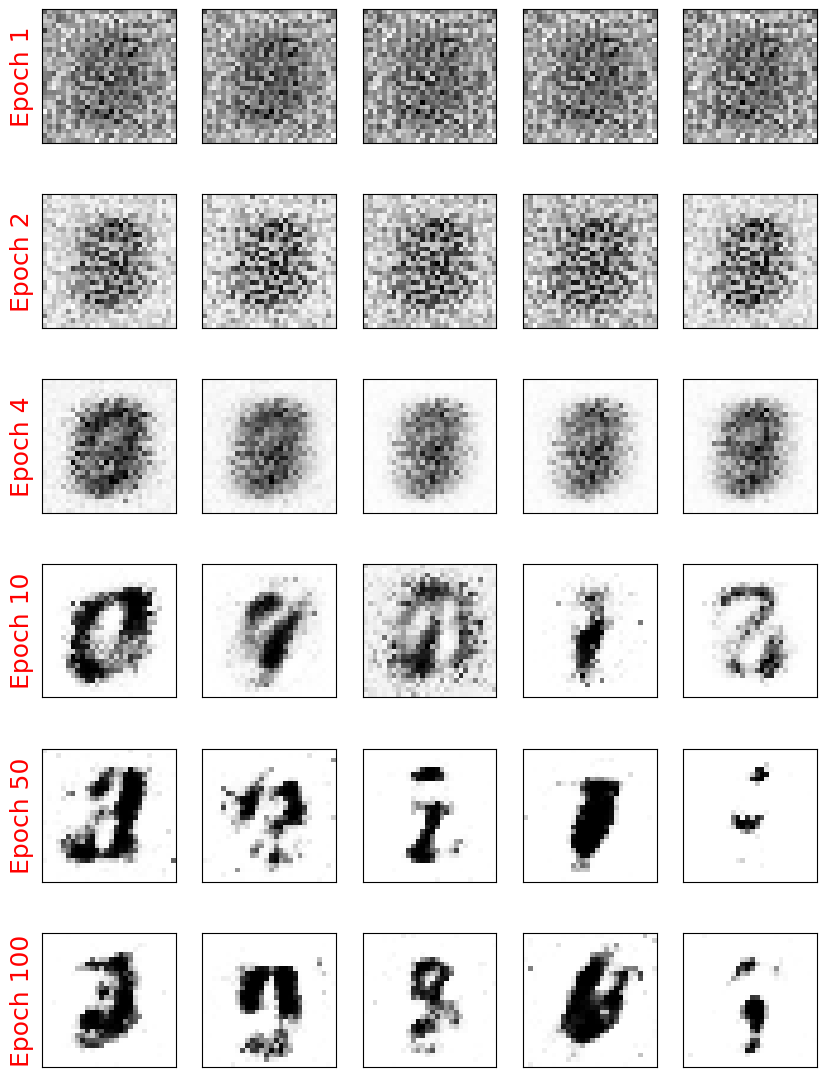

In [20]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])                   
        if j == 0:
            ax.text(
            -0.06, 0.5, 'Epoch {}'.format(e),
            rotation=90, size=18, color='red',
            horizontalalignment='right',
            verticalalignment='center',
            transform=ax.transAxes)
   
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()
